# Use Convolutional Neural Network to Identify Spiral Arms
An EfficientNet Model to classify 3 classes: spiral, early-type (no spiral features), and other types (no spiral features)....
--
Inspired by this reference:
Kalvankar et al. 2020
https://ui.adsabs.harvard.edu/abs/2020arXiv200813611K

### Importing the libraries

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

## Data Preprocessing
### Preprocessing the Training set

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size = (100, 100),
                                                 batch_size = 32,
                                                 seed = 10,
                                                 shuffle = False,
                                                 class_mode = 'categorical')
STEP_SIZE_TRAIN = training_set.n // training_set.batch_size

Found 31848 images belonging to 3 classes.


### Preprocessing the Validation set

In [3]:
valid_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.12)

valid_set = valid_datagen.flow_from_directory('dataset/training',
                                                 target_size = (100, 100),
                                                 batch_size = 32,
                                                 seed = 10,
                                                 shuffle = False,
                                                 class_mode = 'categorical')
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 31848 images belonging to 3 classes.


## Setting up the EfficientNet Model

In [4]:
# !pip install efficientnet

In [5]:
import efficientnet.keras as efn 
from tensorflow import keras
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [6]:
strategy = tf.distribute.get_strategy()

with strategy.scope():
    def build_model():
        eff0 = efn.EfficientNetB7(weights='imagenet',include_top=False,input_shape=(100, 100, 3))
        X = keras.layers.GlobalAveragePooling2D()(eff0.output)
        X = keras.layers.Dropout(0.5)(X)
        X = keras.layers.Dense(64)(X)
        X = keras.layers.Activation('relu')(X)
        X = keras.layers.Dense(3)(X)
        X = keras.layers.Activation('softmax')(X)
        model = keras.models.Model(inputs = eff0.input, outputs = X)
        model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=1.5e-4), 
                  metrics=['accuracy'])
        return model
    
model_enet = build_model()
model_enet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 50, 50, 64)   1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 50, 50, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 50, 50, 64)   0           stem_bn[0][0]                    
______________________________________________________________________________________________

## Training the Model

#### add visualisation
* code block here adapted from https://github.com/kapil-varshney/utilities/blob/master/training_plot/training_plot_ex_with_cifar10.ipynb

In [7]:
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn-talk")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, linestyle=':', label = "train_loss")
            plt.plot(N, self.acc, linestyle=':', label = "train_accuracy")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_accuracy")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()
plot_losses = TrainingPlot()

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

checkpointer = ModelCheckpoint(
    filepath='/Users/tiantianyuan/work/learn_py/self/astro/dataset/wts_enet_modelv1.h5', verbose=2, save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4)

csv_logger = CSVLogger('/Users/tiantianyuan/work/learn_py/self/astro/dataset/train_enet_modelv1.csv')

In [ ]:
import time
t1 = time.time()
results = model_enet.fit(training_set,
                         steps_per_epoch=STEP_SIZE_TRAIN,
                         validation_data=valid_set,
                         validation_steps=STEP_SIZE_VALID,
                         epochs=50,
                         callbacks=[plot_losses, checkpointer, early_stopping, reduce_lr, csv_logger])
t2 = time.time()
print('Model running time is {:.2f}mins'.format((t2 - t1)/60))

Epoch 1/50
409/995 [===========>..................] - ETA: 2:01:32 - loss: 1.1206 - accuracy: 0.3718

### Save models

In [25]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_model
cnn.save('saved_model/enet_spiral_modelv1')

INFO:tensorflow:Assets written to: saved_model/cnn_spiral_modelv4b/assets


In [26]:
cnn.save('saved_model/enet_spiral_modelv1.h5')

### Model evaluation using Confusion Matrix and F1 score

In [27]:
from keras.models import Model,load_model
model_check = load_model('saved_model/enet_spiral_modelv1.h5')

In [32]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            seed = 10, 
                                            shuffle = False,
                                            class_mode = 'categorical')

test_set.reset()

Y_pred = model_check.predict(
    test_set,
    steps=test_set.n / test_set.batch_size,
    verbose=1)

y_pred = np.argmax(Y_pred, axis=1)

Found 9194 images belonging to 3 classes.
287/287 [==============================] - 30s 105ms/step


In [33]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_set.classes, y_pred)

print('The confusion matrix is \n{}\n'.format(cm))

f1 = classification_report(test_set.classes, y_pred, target_names=training_set.class_indices)
print('F1 score is {}\n'.format(f1))

The confusion matrix is 
[[2897  143   22]
 [ 682 1632  752]
 [  68  576 2422]]

F1 score is               precision    recall  f1-score   support

 early_types       0.79      0.95      0.86      3062
  nonspirals       0.69      0.53      0.60      3066
     spirals       0.76      0.79      0.77      3066

    accuracy                           0.76      9194
   macro avg       0.75      0.76      0.75      9194
weighted avg       0.75      0.76      0.75      9194




##  Testing the CNN's performance on individual new images

### Here is a visual representation of the training samples:
<div>
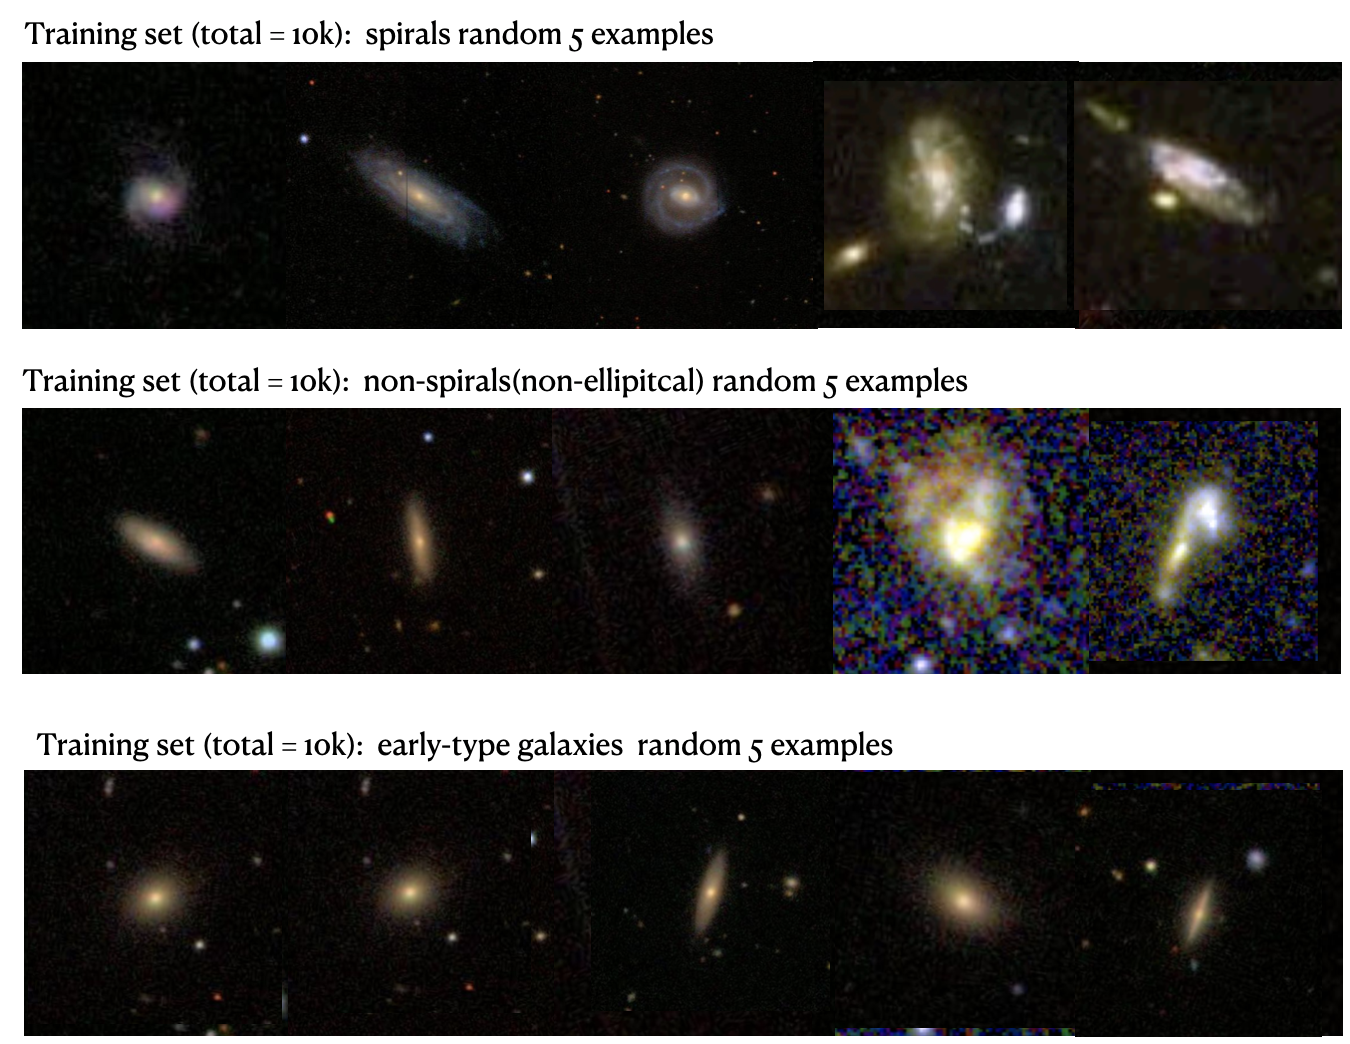
</div>

### We are going to have fun with:   
1. A very well-known nearby large spiral galaxy with beautiful rgb color. 
2. A nearby spiral galaxy from a single-band color.
3. An ancient spiral galaxy (2.6 years after the Big Bang) that is gravitationally lensed.
4. A very distant 'cosmic ring of fire' galaxy
5. Some clumpy high-z galaxies
6. Some nearby and distant early-type (roundish) galaxies.

In [17]:
# check which label is which
training_set.class_indices

{'early_types': 0, 'nonspirals': 1, 'spirals': 2}

In [18]:
from keras.preprocessing import image
def image_in(fileloc, dimx=100, dimy=100):
    """ reshape a raw jpg image into an array that is acceptable by keras models.
    Parameters
    ----------
    fileloc : path and name for the input image
        an input directory under which files are searched.
    dimx, dimy : int
        should be the same as the target_size in the trained CNN
    ----------
    Return
    test_image that can be processed by kera models 
    """
    test_image = image.load_img(fileloc, target_size = (dimx, dimy))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    return test_image

### Prediction 1. 
This is a beautiful nearby spiral galaxy M101. The image is much large and has more details than the training set. 
Would CNN be able to recognise it as as spiral galaxy ?  Let's see.
<div>
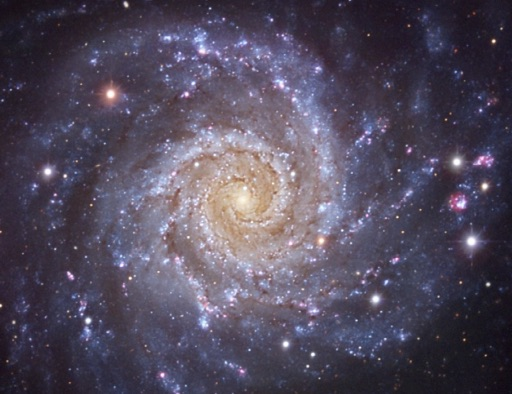
</div>


In [19]:
import numpy as np
fileloc = 'dataset/single_prediction_test/nearby_large.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

print('The predicted label is ', result)

if result[0][2] == 1:
    prediction = 'a spiral galaxy'
elif result[0][1] == 1:
    prediction = 'not a spiral galaxy but a disk'
elif result[0][0] == 1:
    prediction = 'not a spiral galaxy but an elliptical'

print('CNN predicts that the image above is ', prediction)   

The predicted label is  [[1. 0. 0.]]
CNN predicts that the image above is  not a spiral galaxy but an elliptical


### Prediction 2.  
This is also a nearby spiral galaxy. The image is taken using only one filter,  i.e., a single color image.
Would CNN trained on 3-color images be able to recognise it as as spiral galaxy ?  Let's see.

<div>
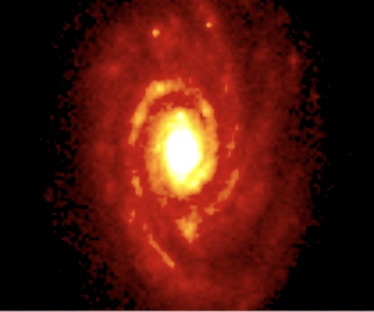
</div>


In [20]:
fileloc = 'dataset/single_prediction_test/spiral_singleband.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

print(result)

if result[0][2] == 1:
    prediction = 'a spiral galaxy'
elif result[0][1] == 1:
    prediction = 'not a spiral galaxy but a disk'
elif result[0][0] == 1:
    prediction = 'not a spiral galaxy but an elliptical'
print('CNN predicts that the image above is ', prediction)   

[[0. 1. 0.]]
CNN predicts that the image above is  not a spiral galaxy but a disk


### Prediction 3. 

This is an ancient spiral galaxy that I studied. Would the CNN trained using 
nearby spiral galaxies be able to identify such a proto-type spiral galaxy ? 
https://en.wikipedia.org/wiki/A1689B11

<div>
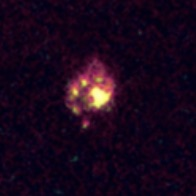
</div>


In [21]:
fileloc = 'dataset/single_prediction_test/ancient_spiral_A1689B11.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

print(result)

if result[0][2] == 1:
    prediction = 'a spiral galaxy'
elif result[0][1] == 1:
    prediction = 'not a spiral galaxy but a disk'
elif result[0][0] == 1:
    prediction = 'not a spiral galaxy but an elliptical'
    
print('CNN predicts that the image above is ', prediction)   

[[0.0000000e+00 3.9114266e-13 1.0000000e+00]]
CNN predicts that the image above is  a spiral galaxy


### Prediction 4:  What about a weird type ? Spiral or non-Spiral ?
This is the cosmic 'ring of fire' galaxy that I discovered. 
https://astronomycommunity.nature.com/posts/a-distant-giant-with-a-ring-on-it

Would the CNN trained using nearby spiral galaxies classify such a ring galaxy as 'spiral' or 'nonspiral'?  I am curious.  Let's see! 
<div>
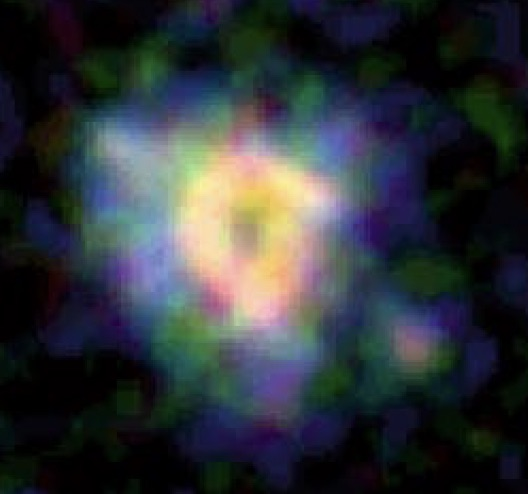
</div>



In [22]:
fileloc = 'dataset/single_prediction_test/cosmic_ring_of_fire.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

if result[0][2] == 1:
    prediction = 'a spiral galaxy'
elif result[0][1] == 1:
    prediction = 'not a spiral galaxy but a disk'
elif result[0][0] == 1:
    prediction = 'not a spiral galaxy but an elliptical'
print('CNN predicts that the image above is ', prediction)   

CNN predicts that the image above is  not a spiral galaxy but an elliptical


### Prediction 5-8:  What about some clumpy high-redshift galaxies and ellipitcals like these ? 
[Successfully predict that they are not spirls]
Images from the CANDELS survey:
<div>
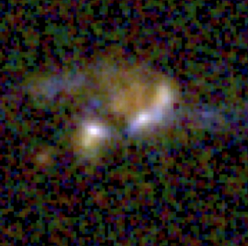
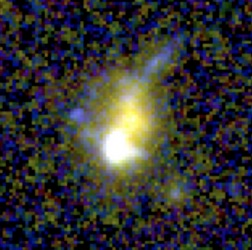
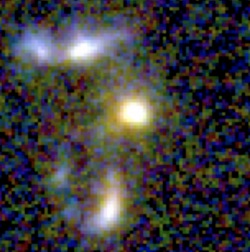
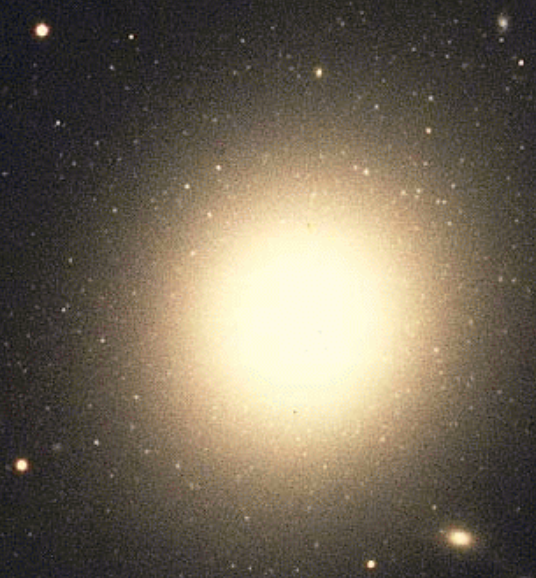
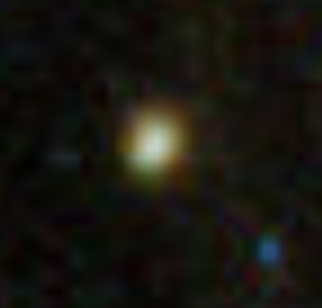

</div>


In [26]:
fileloc = 'dataset/single_prediction_test/clumpy1.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)
if result[0][2] == 1:
    prediction = 'a spiral galaxy'
elif result[0][1] == 1:
    prediction = 'not a spiral galaxy but a disk'
elif result[0][0] == 1:
    prediction = 'not a spiral galaxy but an elliptical'
    
print('CNN predicts that clumpy1 is ', prediction)  

fileloc = 'dataset/single_prediction_test/clumpy2.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

if result[0][2] == 1:
    prediction = 'a spiral galaxy'
elif result[0][1] == 1:
    prediction = 'not a spiral galaxy but a disk'
elif result[0][0] == 1:
    prediction = 'not a spiral galaxy but an elliptical'
print('CNN predicts that clumpy2 is ', prediction)   

fileloc = 'dataset/single_prediction_test/clumpy3.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

if result[0][2] == 1:
    prediction = 'a spiral galaxy'
elif result[0][1] == 1:
    prediction = 'not a spiral galaxy but a disk'
elif result[0][0] == 1:
    prediction = 'not a spiral galaxy but an elliptical'
print('CNN predicts that clumpy3 is ', prediction)  



fileloc = 'dataset/single_prediction_test/low-z_early1.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

if result[0][2] == 1:
    prediction = 'a spiral galaxy'
elif result[0][1] == 1:
    prediction = 'not a spiral galaxy but a disk'
elif result[0][0] == 1:
    prediction = 'not a spiral galaxy but an elliptical'
print('CNN predicts that low-z_early1 is ', prediction)   

fileloc = 'dataset/single_prediction_test/high-z_early1.jpg'
image_pred = image_in(fileloc)
result = cnn.predict(image_pred)

if result[0][2] == 1:
    prediction = 'a spiral galaxy'
elif result[0][1] == 1:
    prediction = 'not a spiral galaxy but a disk'
elif result[0][0] == 1:
    prediction = 'not a spiral galaxy but an elliptical'
    
print('CNN predicts that high-z_early1 is ', prediction)   

CNN predicts that clumpy1 is  not a spiral galaxy but an elliptical
CNN predicts that clumpy2 is  not a spiral galaxy but an elliptical
CNN predicts that clumpy3 is  not a spiral galaxy but a disk
CNN predicts that low-z_early1 is  not a spiral galaxy but a disk
CNN predicts that high-z_early1 is  not a spiral galaxy but an elliptical


### Comment
0. This model (3) performs the best so far
1. This model only fails on a gravationationlly lensed spiral (we will try again using source-reconstructed image)

The next step is to train a 4th model (cnn_spiral_model4) using 3 categories, spiral, nonspiral (non elliptical) and elliptical.